# Gym-Members-Analysis

# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import roc_curve as sklearn_roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# Functions

In [3]:
def check_nulls_dupes(df):
  print(f"The Amount of Null Values: {df.isna().sum()}")
  print(f"The Amount of Duplicated Values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(12, 10))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(15, 10))
  sns.countplot(x=target)
  plt.xlabel("Target Classes")
  plt.ylabel("Counts")
  plt.show()

def plot_dataset(df, visual_type):
  
  plt.figure(figsize=(16,16))
  cols = len(df.columns)
  rows = (cols +3)//4
  
  for idx, col in enumerate(df.columns):
    plt.subplot(rows, 4, idx+1)
    plt.title(col)
    sns.histplot(data=df[col], kde=True) if visual_type == "hist" else sns.boxplot(df[col])
    plt.xlabel(col)
  
  plt.tight_layout()
  plt.show()

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

def find_outliers_isolation_forest(df):
    outlier_df = df.copy()
    iso_forest = IsolationForest(contamination=0.05)  # Adjust contamination level as needed
    for col in outlier_df.columns:
        outlier_df[f'{col}_outlier'] = iso_forest.fit_predict(df[[col]])
    return outlier_df

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = sklearnPipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = sklearnPipeline(
    steps =[
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor, model, kbest=None):
  
  steps = [
      ("preprocessor", preprocessor),
      ("model", model)
    ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
    
  return sklearnPipeline(
    steps = steps
  )

def plot_roc_curve(X,y, preprocessor, model, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)
  pipeline = create_sklearn_pipeline(preprocessor, model, kbest)
  
  pipeline.fit(X_train, y_train)
  y_scores = pipeline.predict_proba(X_test)[:, 1]
  
  fpr, tpr, thresholds = sklearn_roc_curve(y_test, y_scores)
  roc_auc = auc(fpr, tpr)
  print(f"The AUC is: {roc_auc:.2f}")

  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(14, 10))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(14, 10))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "CAT": CatBoostClassifier(verbose=0),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]
def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, kbest=None):
  means, variances, std_devs, test_accs, recalls, precisions, f1_scores = [], [], [], [], [], [], []
  metric_tracker = []
  for model, model_name in zip(models, model_names):
    if kbest:
        pipeline = create_sklearn_pipeline(preprocessor, model, kbest)
    else:
        pipeline = create_sklearn_pipeline(preprocessor, model)
    
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
    
    means.append(scores[0])
    variances.append(scores[1])
    std_devs.append(scores[2])
    test_accs.append(scores[3])
    recalls.append(scores[4])
    precisions.append(scores[5])
    f1_scores.append(scores[6])
    
  plt.figure(figsize=(12, 8))
  models_index = range(len(model_names)) 
  plt.plot(models_index, means, marker='o', label='Mean')
  plt.plot(models_index, test_accs, marker='^', label='Test Accuracy')
  plt.plot(models_index, f1_scores, marker='s', label='F1 Score')
  plt.xticks(models_index, model_names, rotation=45) 
  plt.xlabel('Models')
  plt.ylabel('Scores')
  plt.title('Comparison of Model Performance')
  plt.legend()
  plt.grid(True)
  plt.show()
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  return performance_df

def test_kbest_columns(preprocessor, X, y, model, model_name, kbest):
  acc_scores = []
  f1_scores = []
  recall_scores = []
  precision_scores = []
  ks = []
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(preprocessor, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    all_transformed_features = pipeline.named_steps['preprocessor'].get_feature_names_out()
    selected_mask = pipeline.named_steps["Feature Selection"].get_support()
    selected_features = all_transformed_features[selected_mask]
    
    cleaned_features = [col.replace("numeric__", "").replace("cat__", "") for col in selected_features]

    ks.append(k)
    acc_scores.append(acc)
    f1_scores.append(f1_metric)
    recall_scores.append(recall_metric)
    precision_scores.append(precision_metric)
    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "Selected Featured":", ".join(cleaned_features),
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  plt.figure(figsize=(10, 8))
  plt.plot(ks, acc_scores, marker='o', label='Accuracy')
  plt.plot(ks, f1_scores, marker='o', label='F1 Score')
  plt.plot(ks, recall_scores, marker='o', label='Recall')
  plt.plot(ks, precision_scores, marker='o', label='Precision')
  plt.xlabel('Number of Features Selected (k)')
  plt.ylabel('Score')
  plt.title('Model Performance Metrics vs. Number of Features')
  plt.legend()
  plt.grid(True)
  plt.show()
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  best_models = []
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sklearn_pipeline(preprocessor, model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=15, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    plot_confusion_matrix(y_test, y_pred, model_name)
    best_models.append(best_model)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return [pd.DataFrame(metric_tracker).sort_values(by="F1-Score", ascending=False), best_models]

def test_stacking_models(X, y, models, model_names):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  for model_name, model in zip(model_names, models):
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker).sort_values(by="Test-Acc", ascending=False)

def get_feature_names(column_transformer):
    """Get feature names from all transformers in ColumnTransformer."""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'named_steps'): 
                if 'Encoder' in pipe.named_steps: 
                    feature_names = pipe.named_steps['Encoder'].get_feature_names_out(features)
                    output_features.extend(feature_names)
                else:
                    output_features.extend(features)
            else:
                output_features.extend(features)
        else:
            output_features.extend(features)
    return output_features

# EDA Analysis

In [4]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24,Male,87.1,1.74,187,158,67,1.57,1364.0,Strength,10.0,3.5,4,3,28.77
969,25,Male,66.6,1.61,184,166,56,1.38,1260.0,Strength,25.0,3.0,2,1,25.69
970,59,Female,60.4,1.76,194,120,53,1.72,929.0,Cardio,18.8,2.7,5,3,19.50
971,32,Male,126.4,1.83,198,146,62,1.10,883.0,HIIT,28.2,2.1,3,2,37.74


# Check For Null Values

In [5]:
check_nulls_dupes(df)

The Amount of Null Values: Age                              0
Gender                           0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Workout_Type                     0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
dtype: int64
The Amount of Duplicated Values: 0


# Check Class Balance

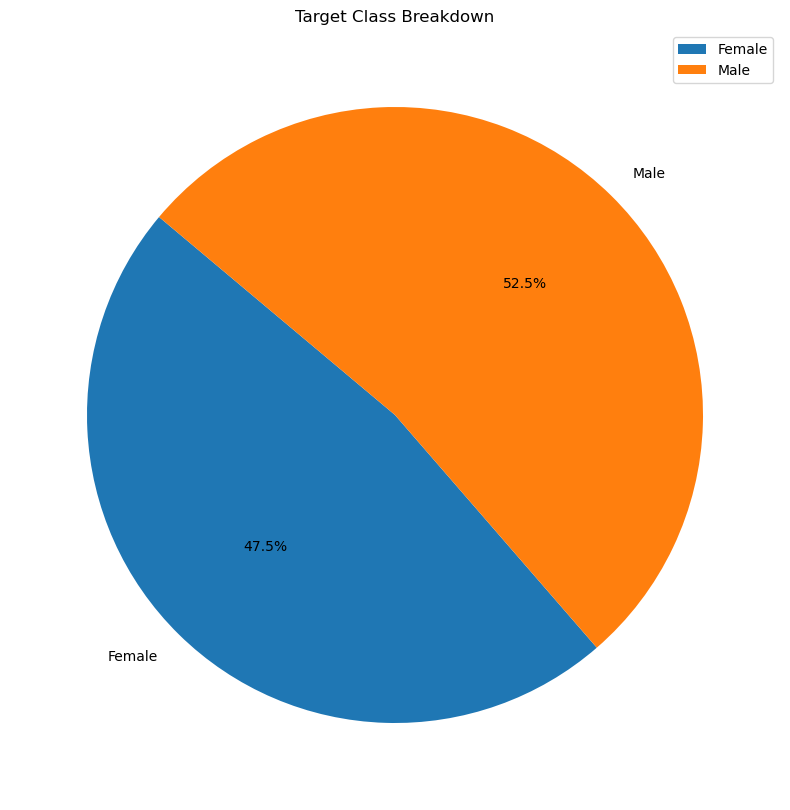

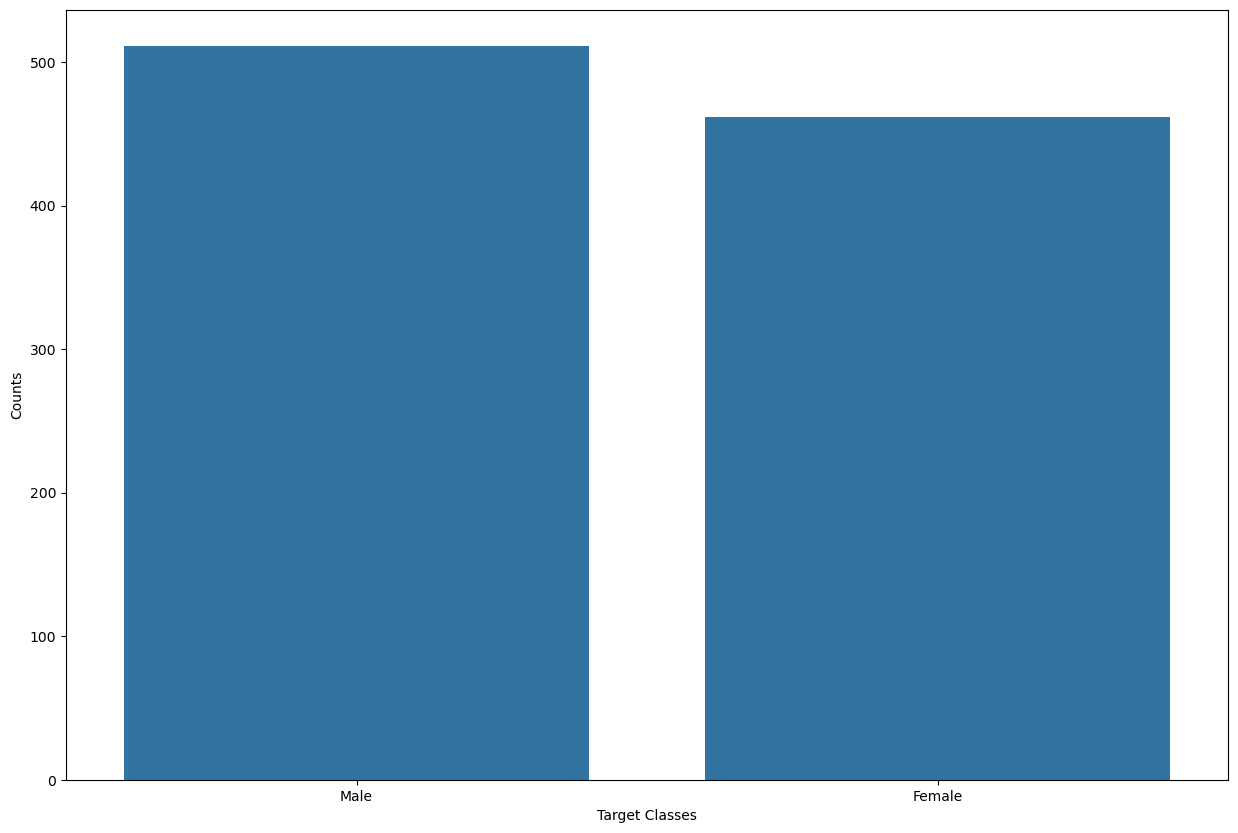

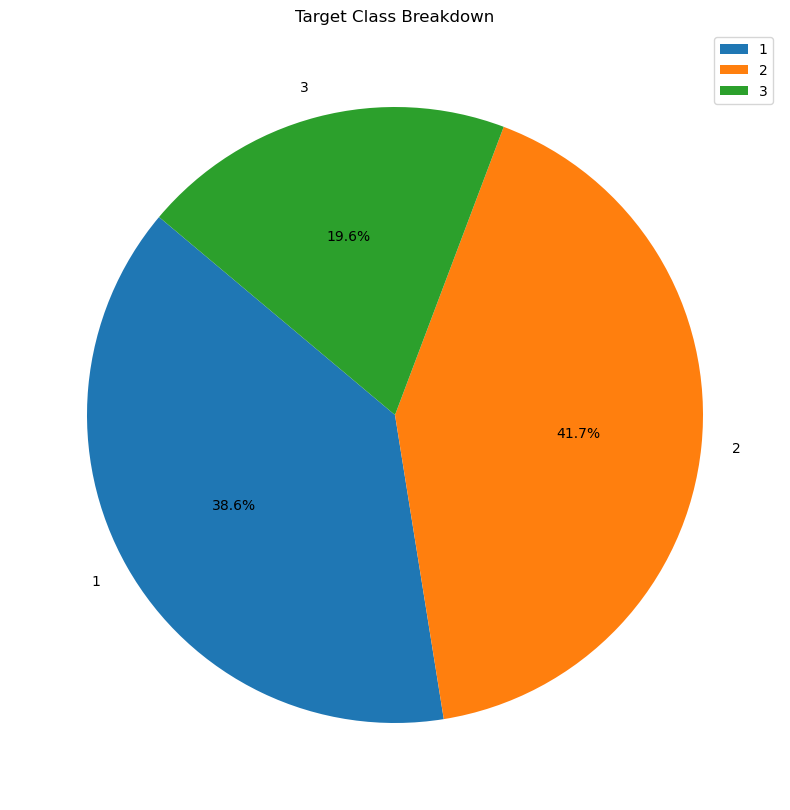

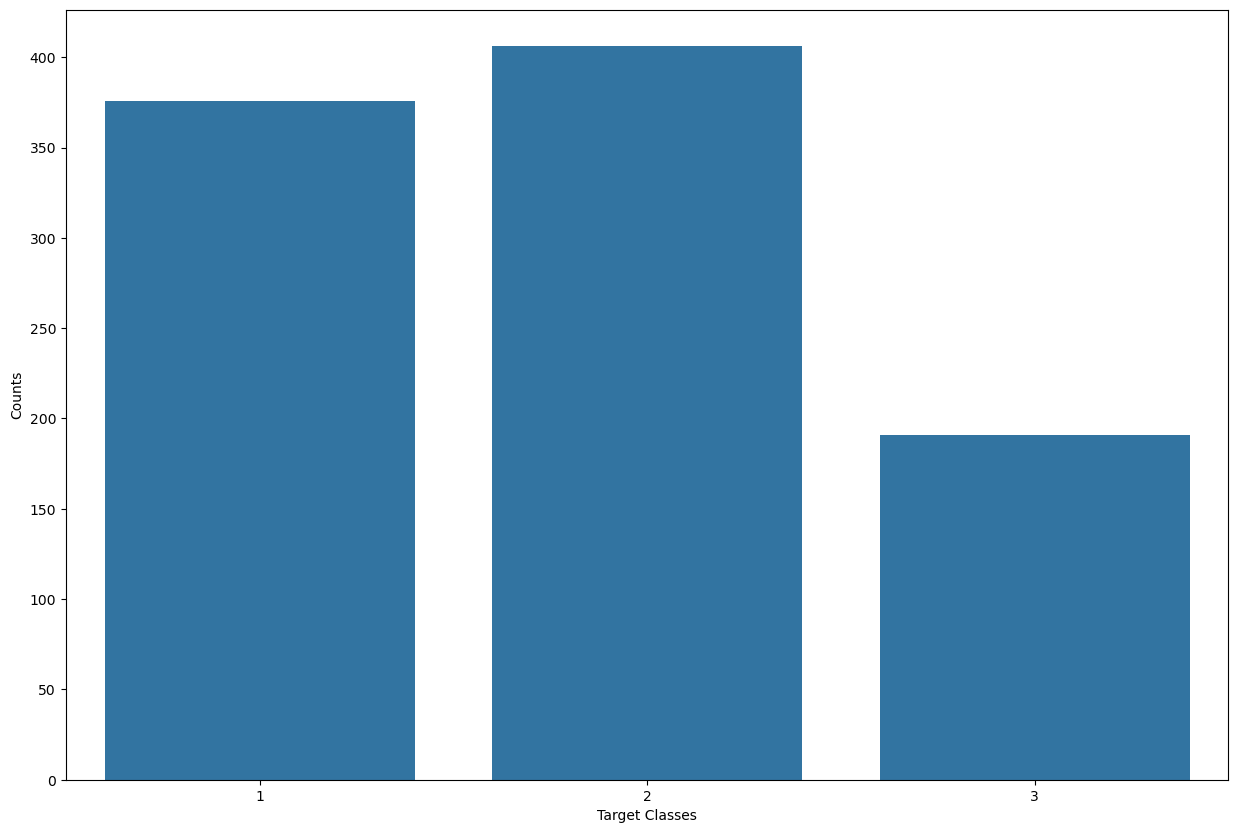

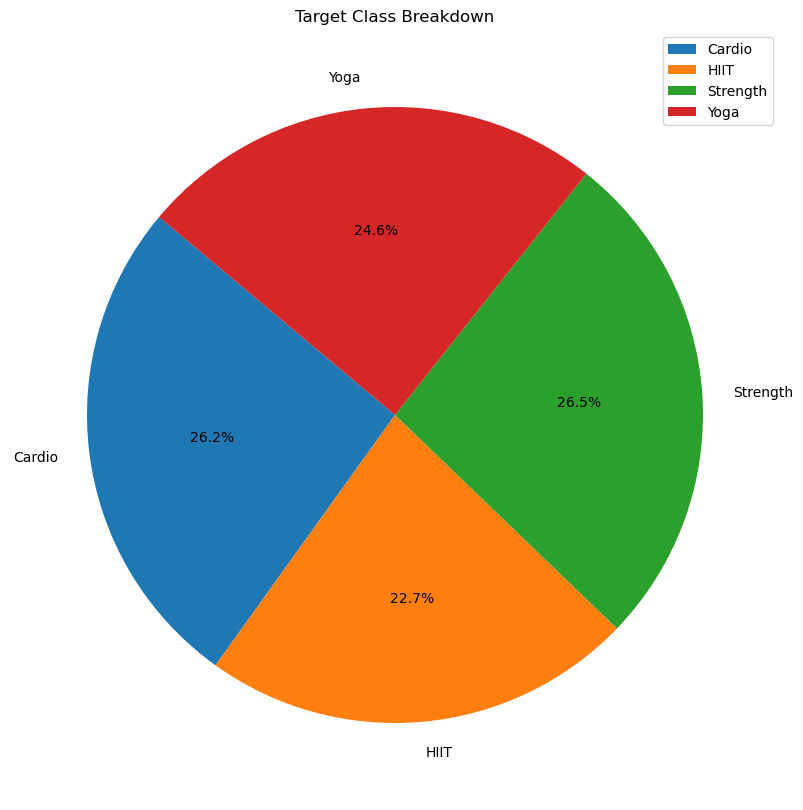

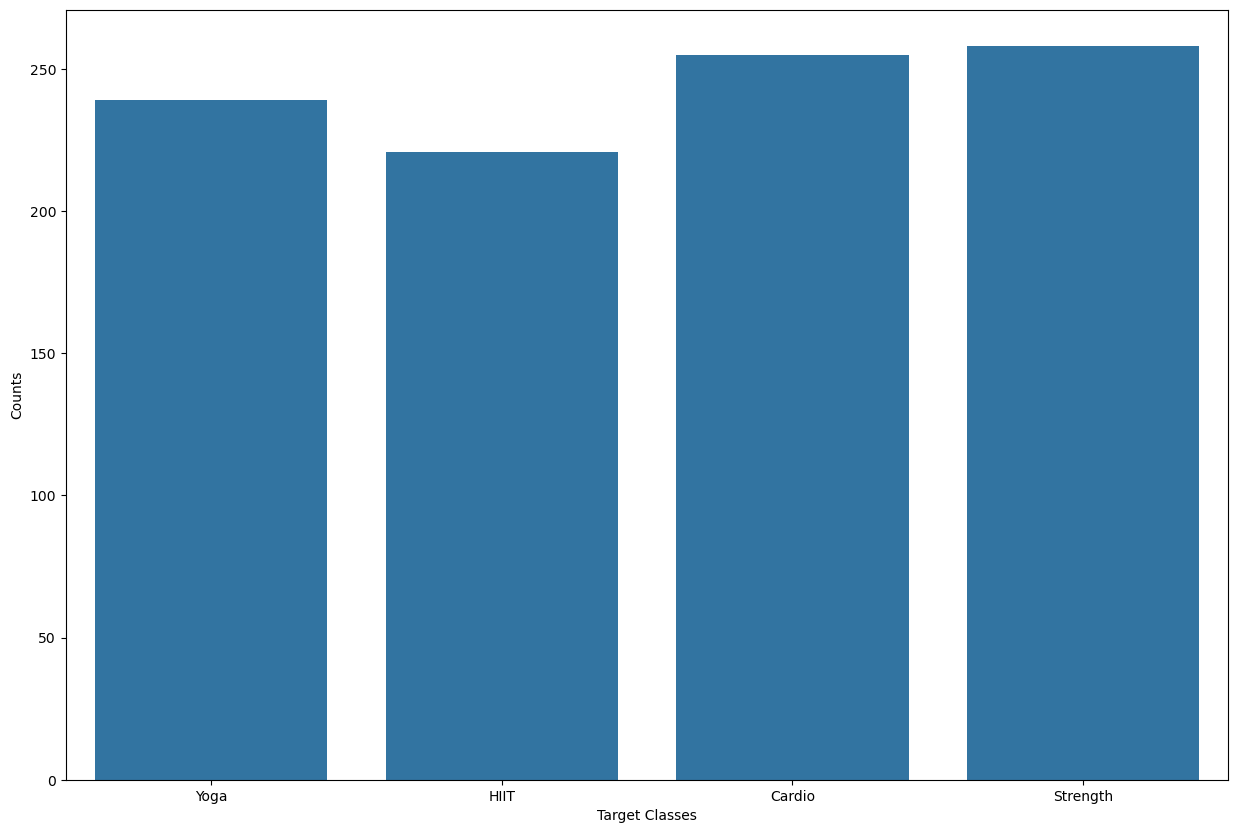

In [6]:
check_class_imbalance(df["Gender"])
check_class_imbalance(df["Experience_Level"])
check_class_imbalance(df["Workout_Type"])

In [7]:
df.describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,24.976773,2.626619,3.321686,1.809866,24.912127
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,6.259419,0.600172,0.913047,0.739693,6.660879
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.320000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,3.000000,1.000000,20.110000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,26.200000,2.600000,3.000000,2.000000,24.160000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,29.300000,3.100000,4.000000,2.000000,28.560000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,49.840000


In [8]:
categorical_types = df.select_dtypes(include="object")
numerical_types = df.select_dtypes(exclude="object")

<AxesSubplot:>

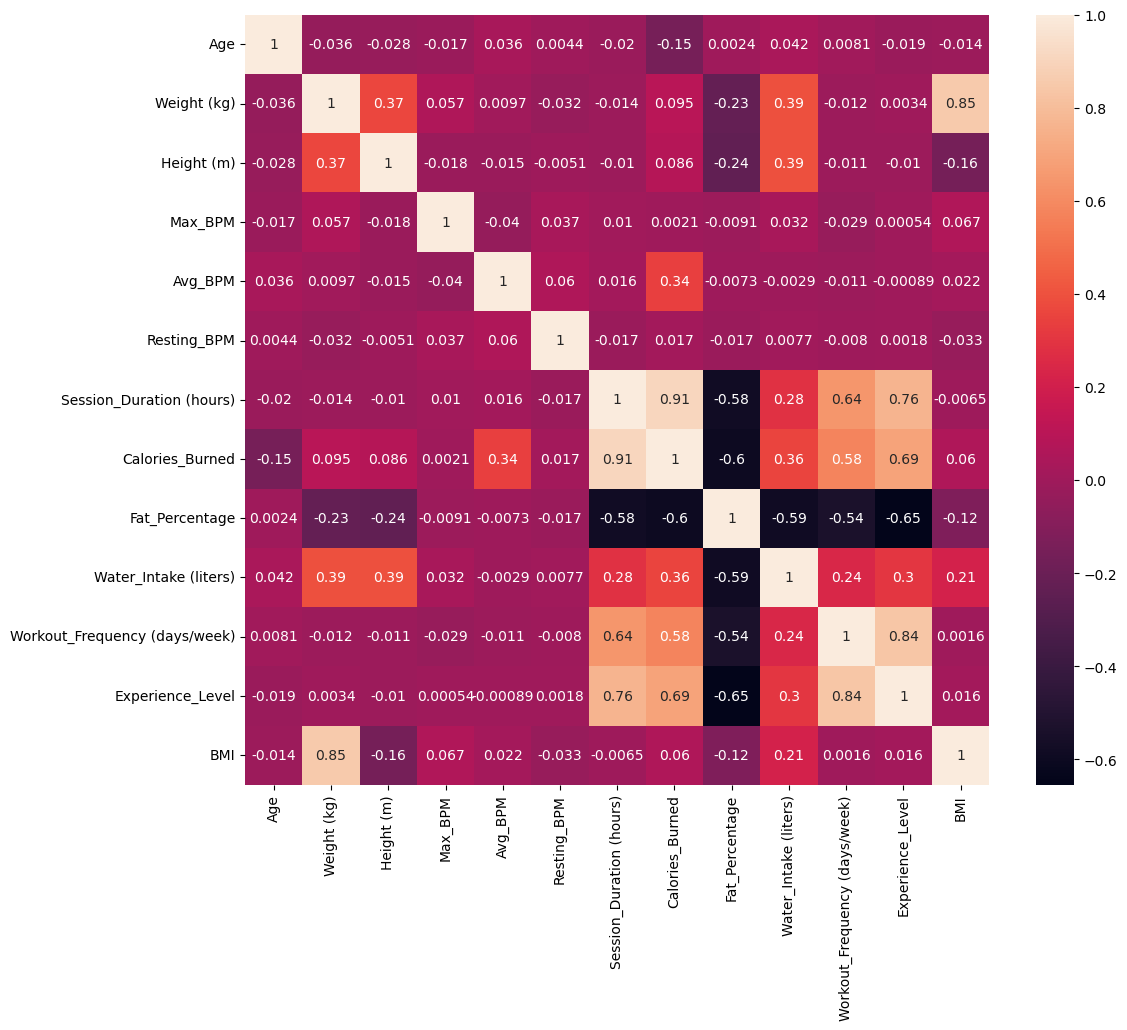

In [9]:
relations = numerical_types.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(data=relations, annot=True)

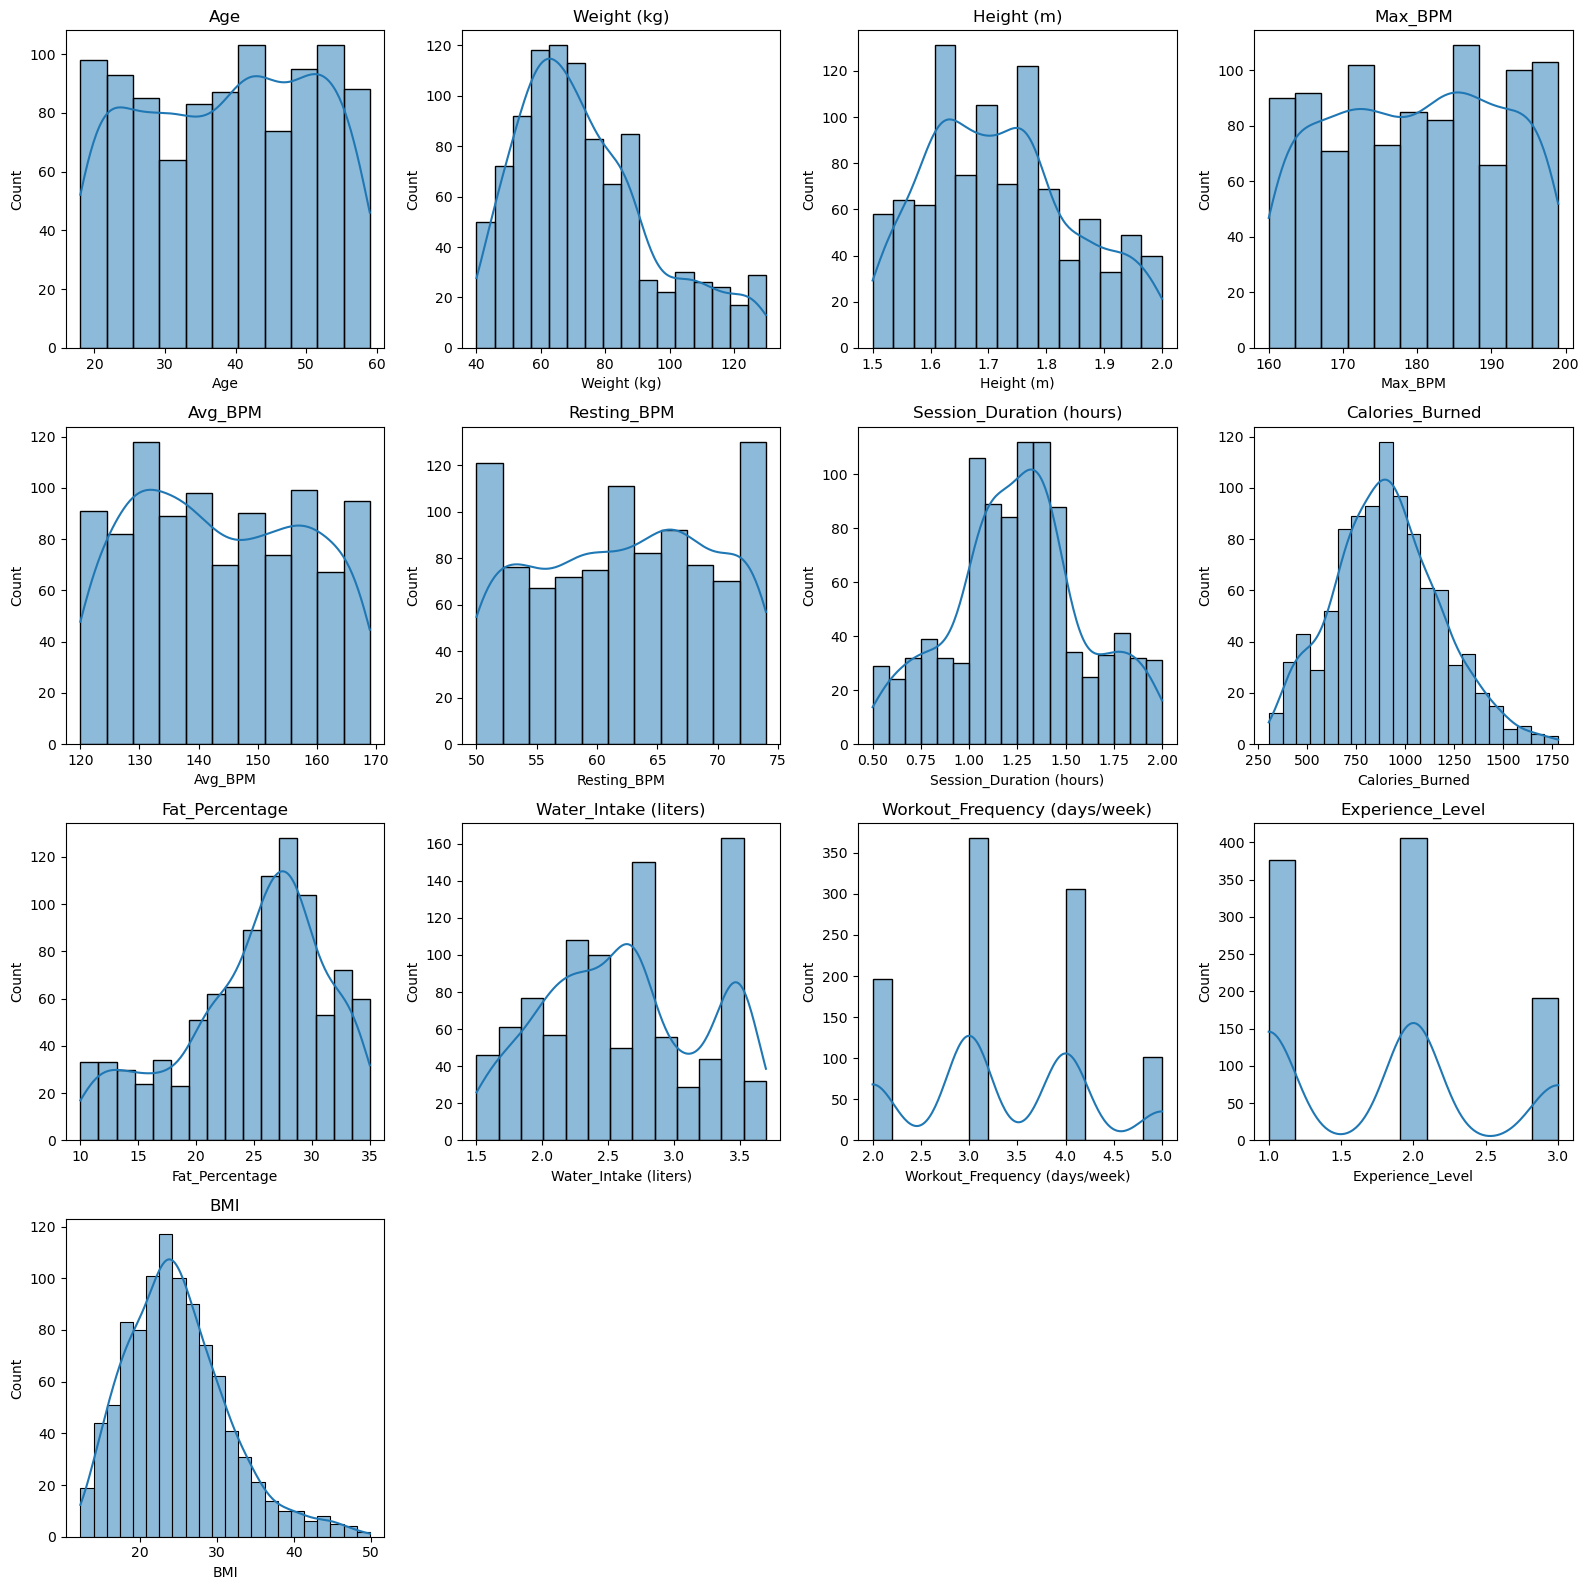

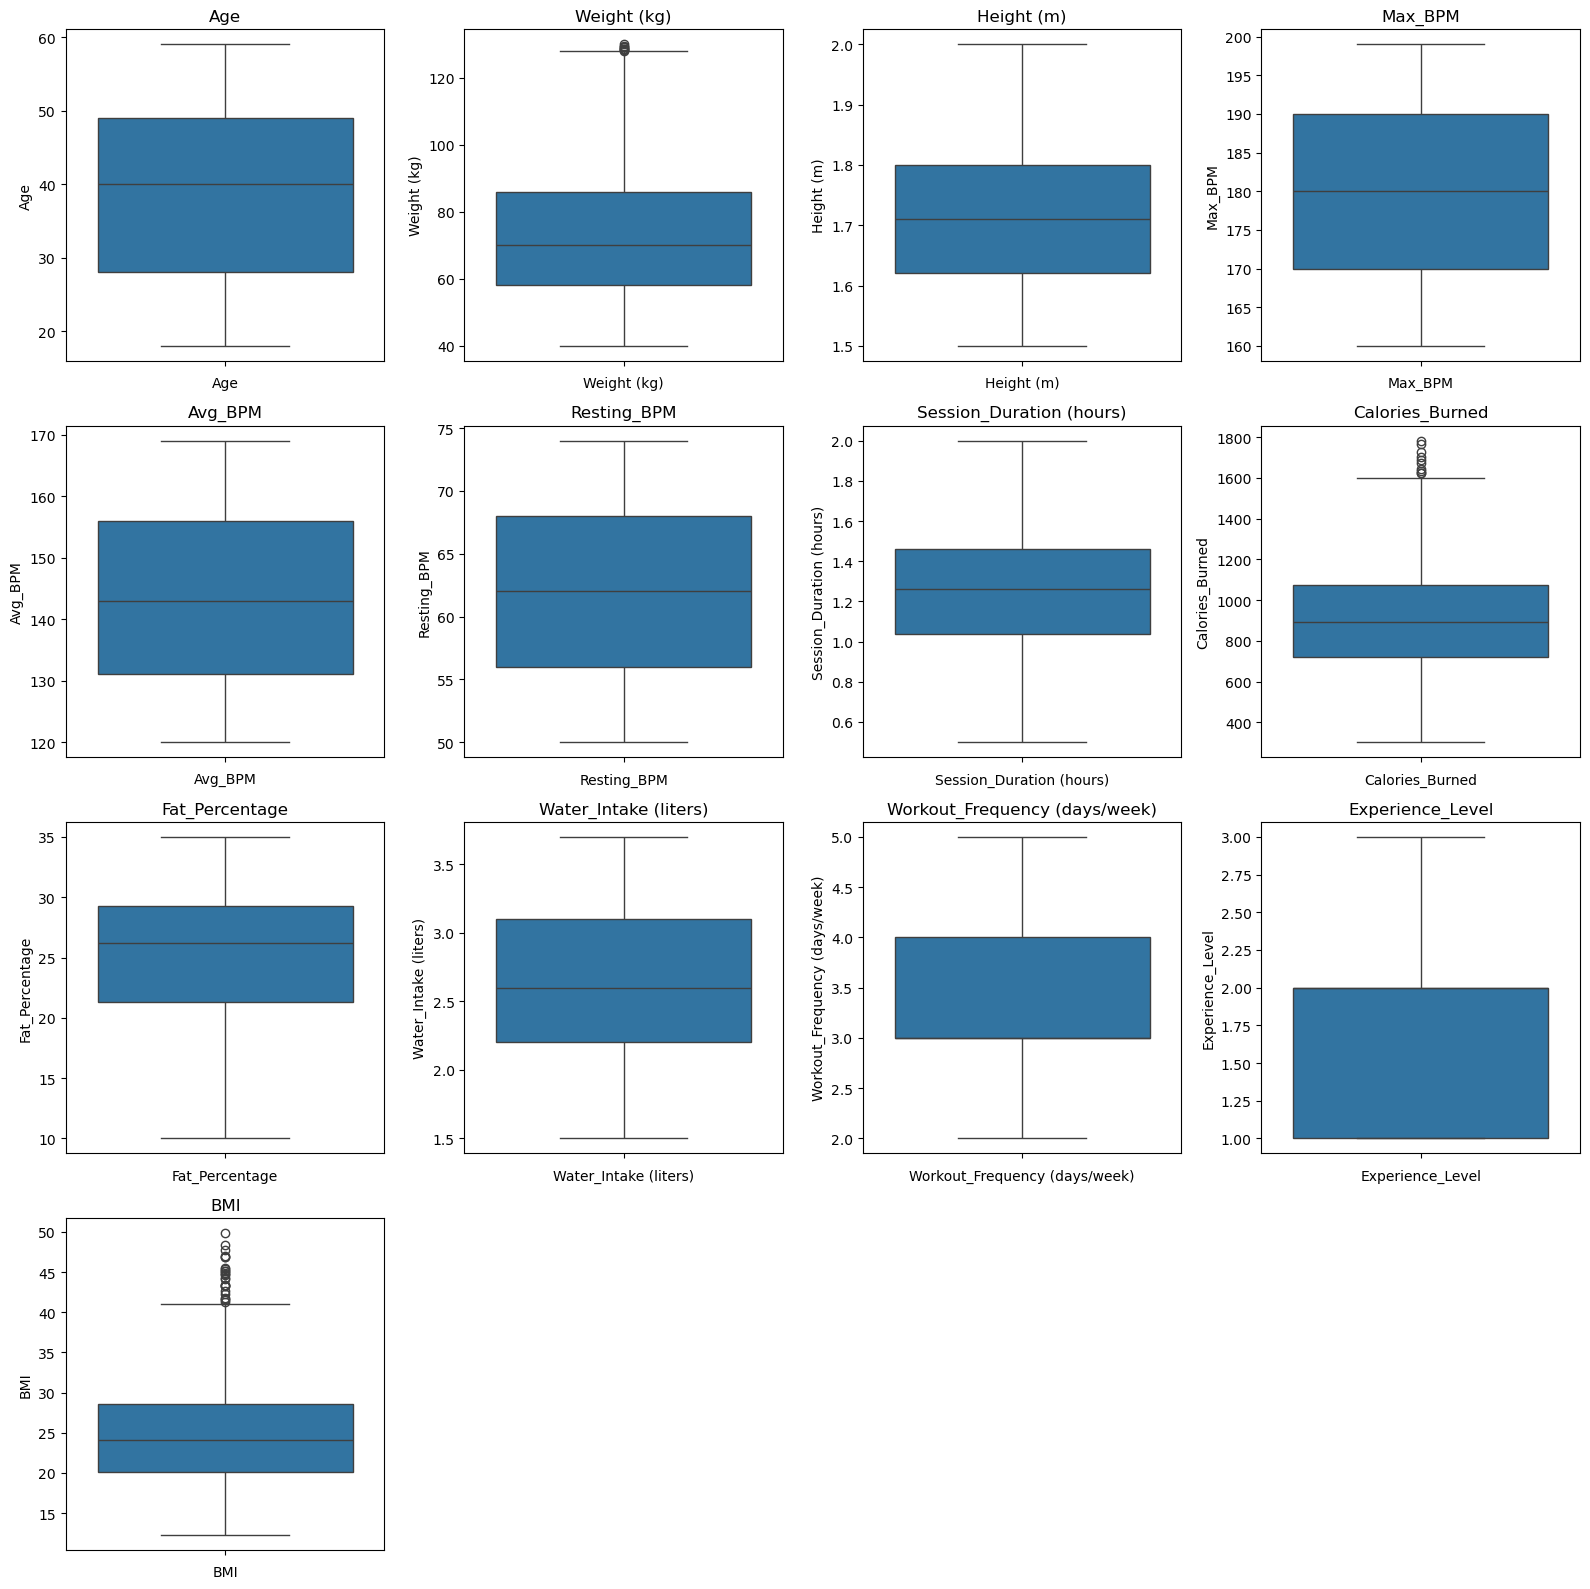

In [10]:
plot_dataset(numerical_types, "hist")
plot_dataset(numerical_types, "box")

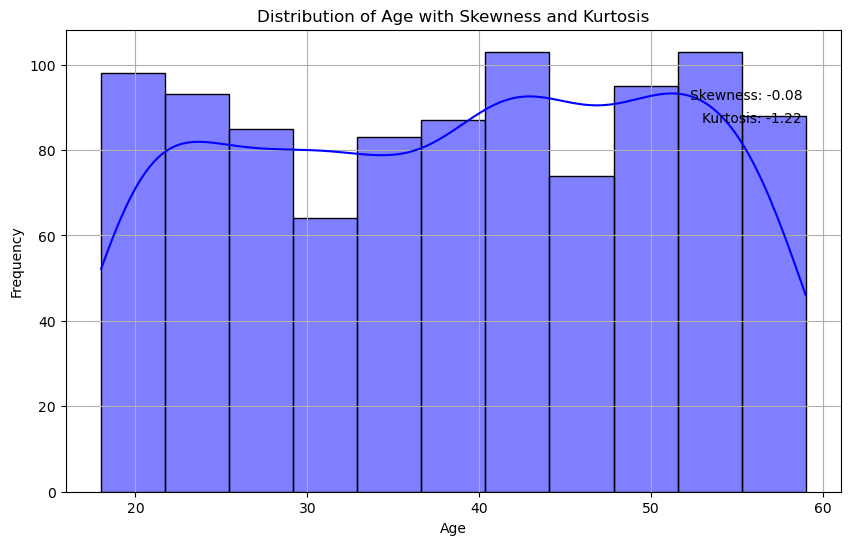

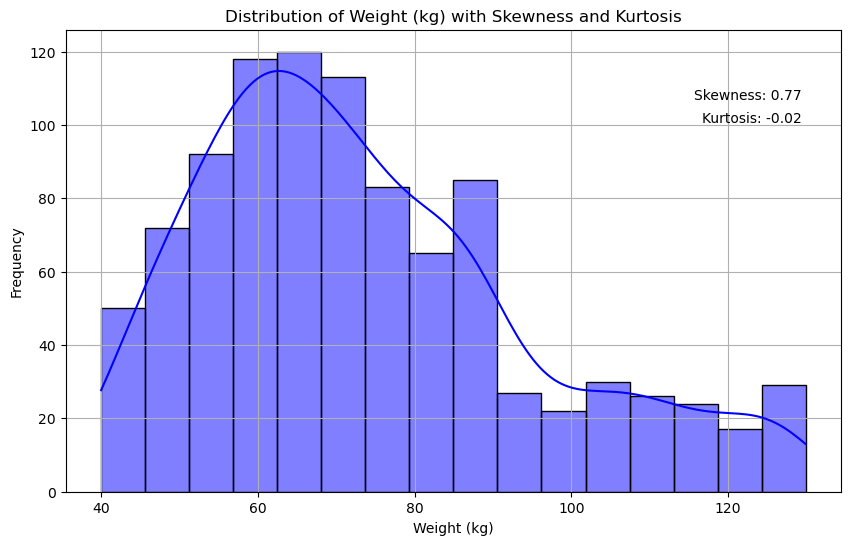

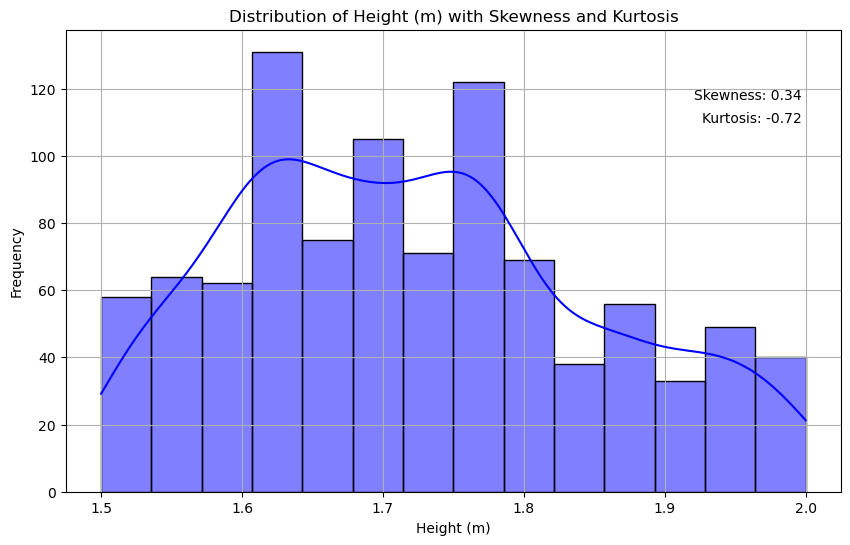

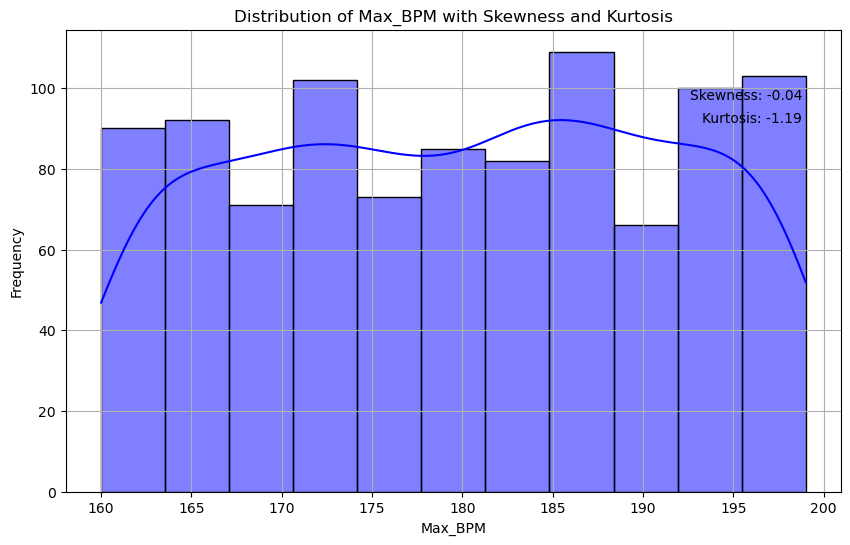

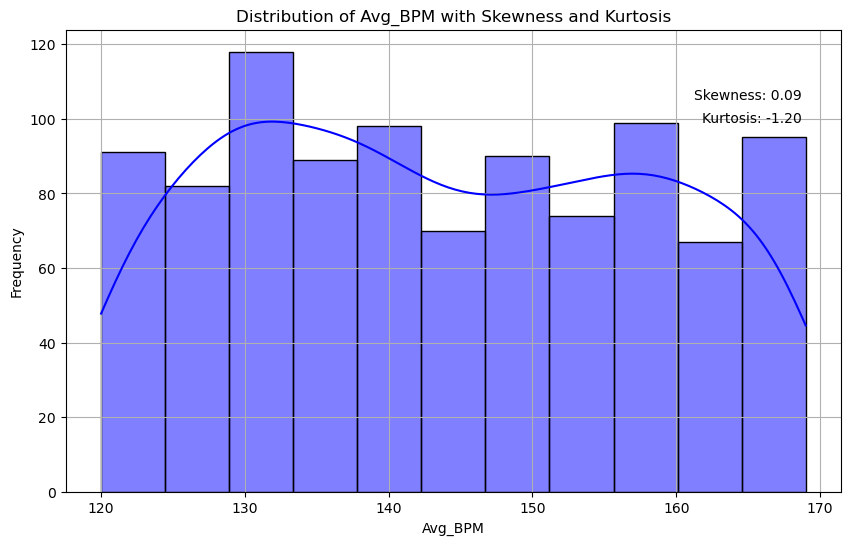

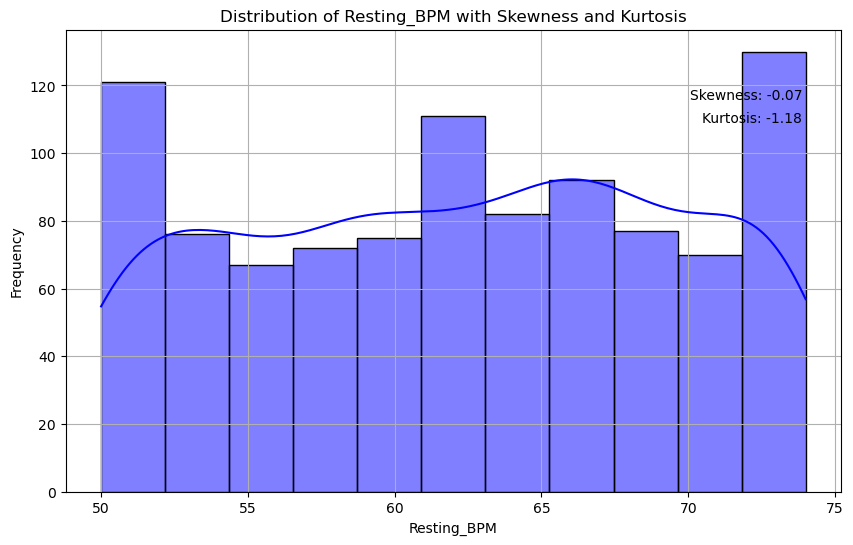

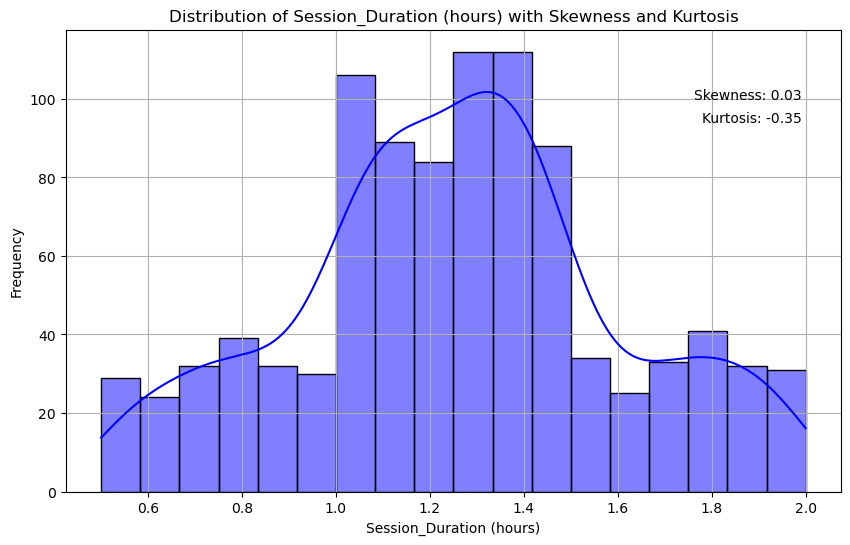

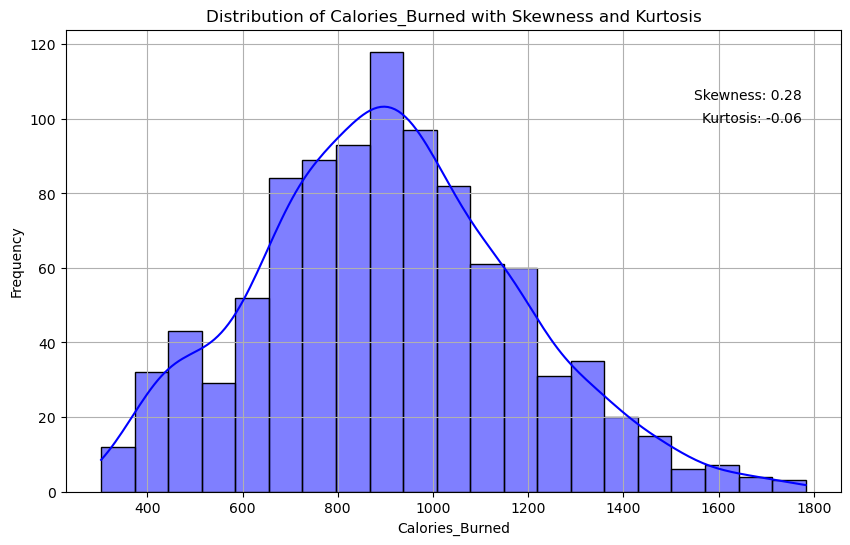

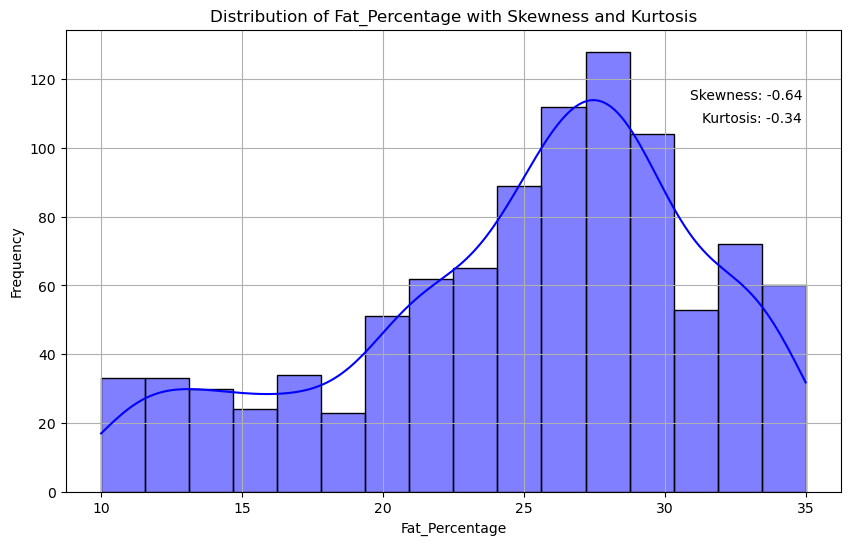

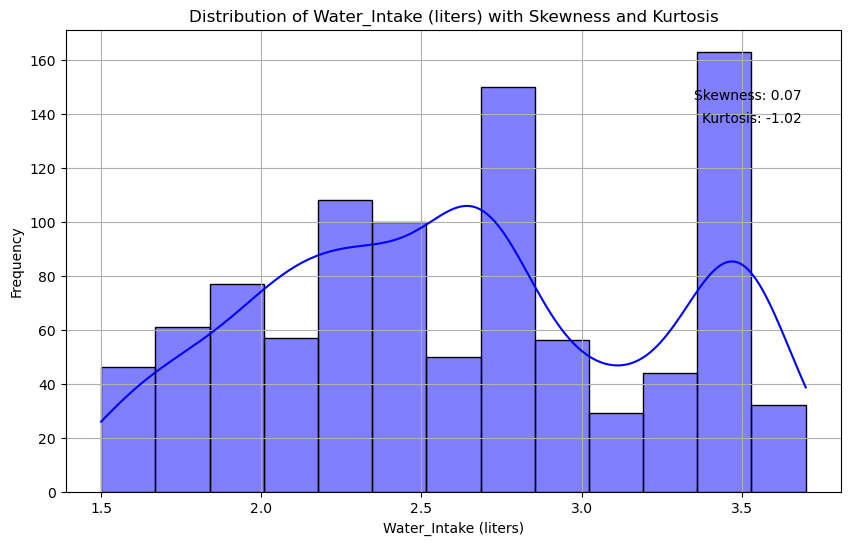

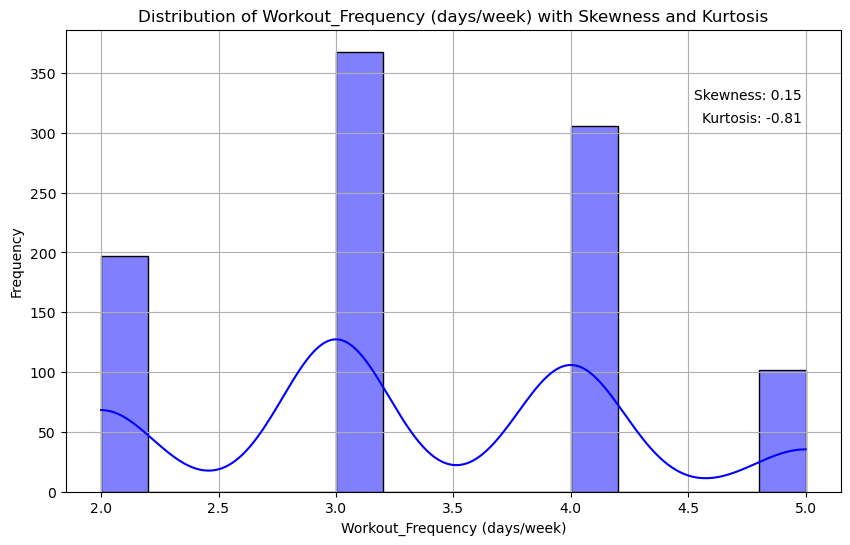

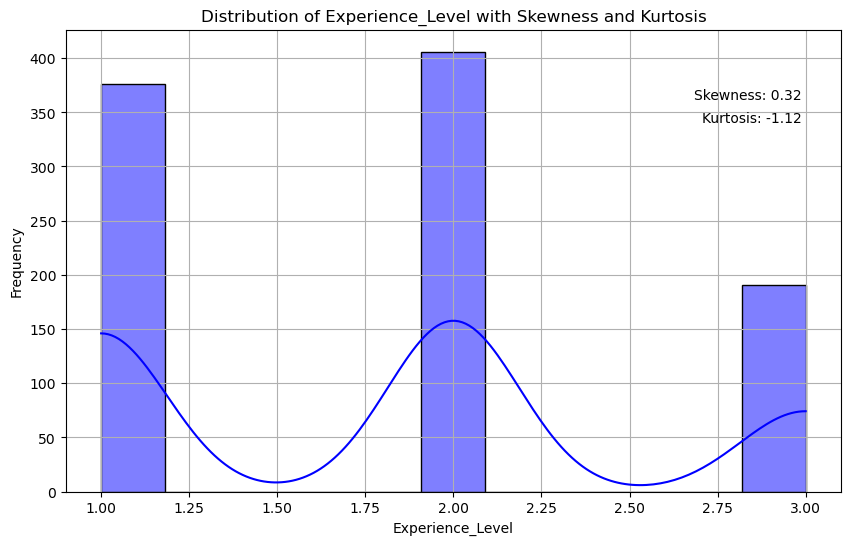

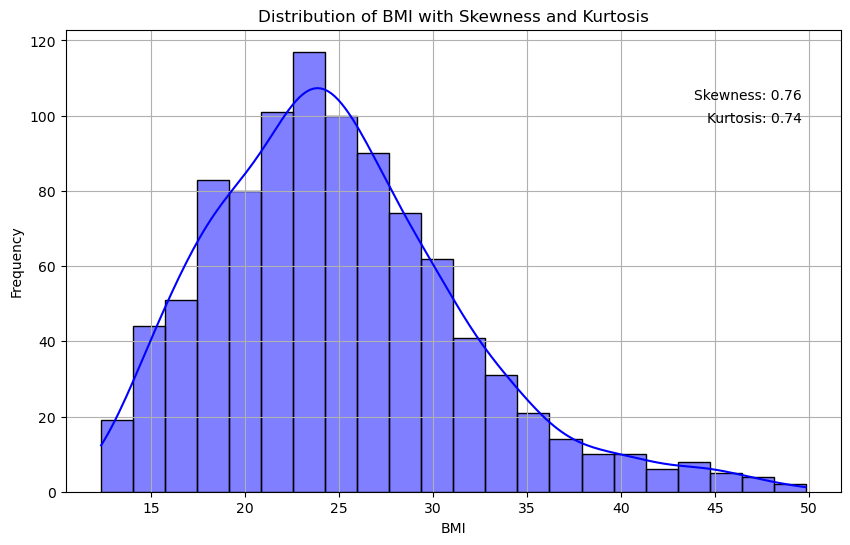

In [11]:
dist_plot(numerical_types)

In [12]:
outlier_df = find_outliers_isolation_forest(numerical_types)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X do

In [13]:
outlier_df[outlier_df["Fat_Percentage_outlier"] == -1].describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),...,Max_BPM_outlier,Avg_BPM_outlier,Resting_BPM_outlier,Session_Duration (hours)_outlier,Calories_Burned_outlier,Fat_Percentage_outlier,Water_Intake (liters)_outlier,Workout_Frequency (days/week)_outlier,Experience_Level_outlier,BMI_outlier
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,...,49.000000,49.000000,49.000000,49.000000,49.000000,49.0,49.0,49.0,49.0,49.000000
mean,37.306122,72.295918,1.738980,179.653061,141.693878,62.836735,1.418980,1037.653061,23.344898,2.789796,...,0.877551,0.877551,0.959184,0.795918,0.673469,-1.0,1.0,1.0,1.0,0.959184
std,12.105791,14.943518,0.133966,10.369328,14.835492,5.906730,0.360053,372.408297,12.217202,0.709238,...,0.484452,0.484452,0.285714,0.611678,0.746876,0.0,0.0,0.0,0.0,0.285714
min,19.000000,42.200000,1.500000,160.000000,120.000000,50.000000,0.610000,415.000000,10.000000,1.600000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,1.0,1.0,1.0,-1.000000
25%,26.000000,63.100000,1.630000,172.000000,128.000000,58.000000,1.130000,734.000000,10.500000,2.200000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0,1.0,1.0,1.0,1.000000
50%,37.000000,72.900000,1.710000,181.000000,142.000000,63.000000,1.410000,1010.000000,34.400000,2.600000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0,1.0,1.0,1.0,1.000000
75%,46.000000,85.700000,1.850000,187.000000,153.000000,67.000000,1.720000,1287.000000,34.700000,3.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0,1.0,1.0,1.0,1.000000
max,59.000000,89.800000,1.990000,199.000000,169.000000,74.000000,1.980000,1783.000000,35.000000,3.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0,1.0,1.0,1.0,1.000000


In [14]:
df

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24,Male,87.1,1.74,187,158,67,1.57,1364.0,Strength,10.0,3.5,4,3,28.77
969,25,Male,66.6,1.61,184,166,56,1.38,1260.0,Strength,25.0,3.0,2,1,25.69
970,59,Female,60.4,1.76,194,120,53,1.72,929.0,Cardio,18.8,2.7,5,3,19.50
971,32,Male,126.4,1.83,198,146,62,1.10,883.0,HIIT,28.2,2.1,3,2,37.74


In [15]:
df.columns

Index(['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
       'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Workout_Type', 'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI'],
      dtype='object')

<AxesSubplot:xlabel='Avg_BPM', ylabel='Calories_Burned'>

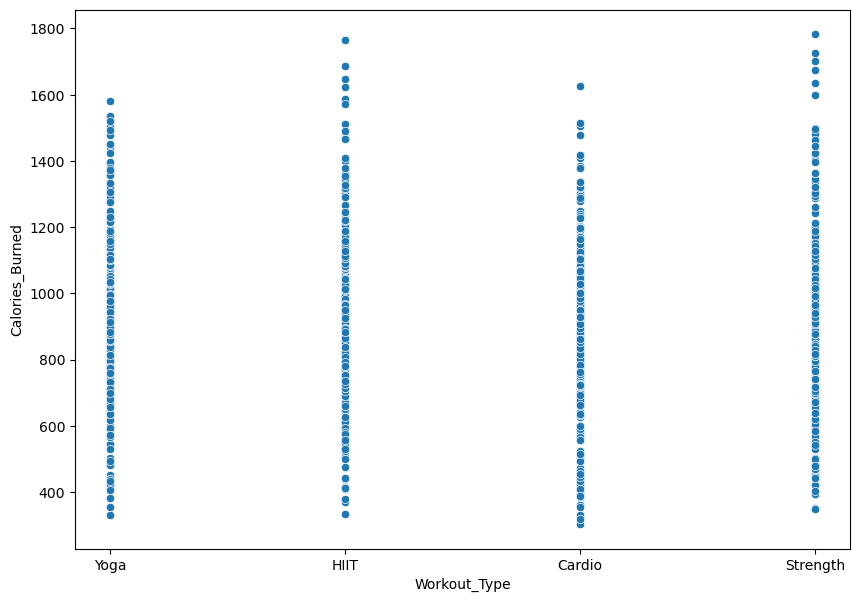

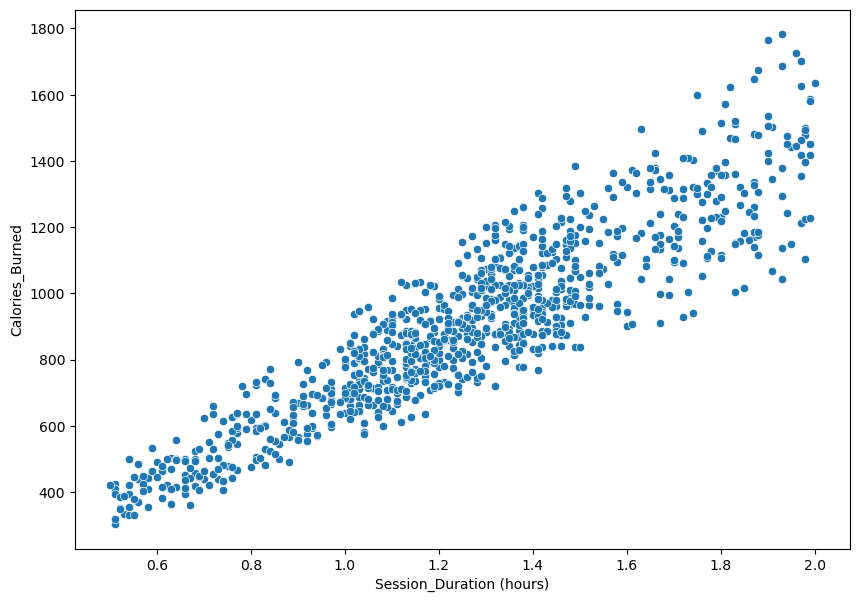

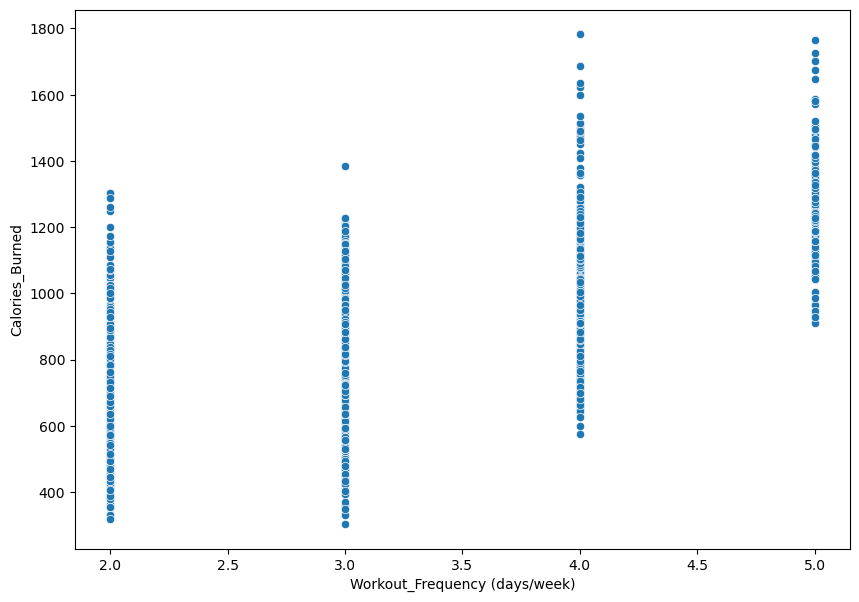

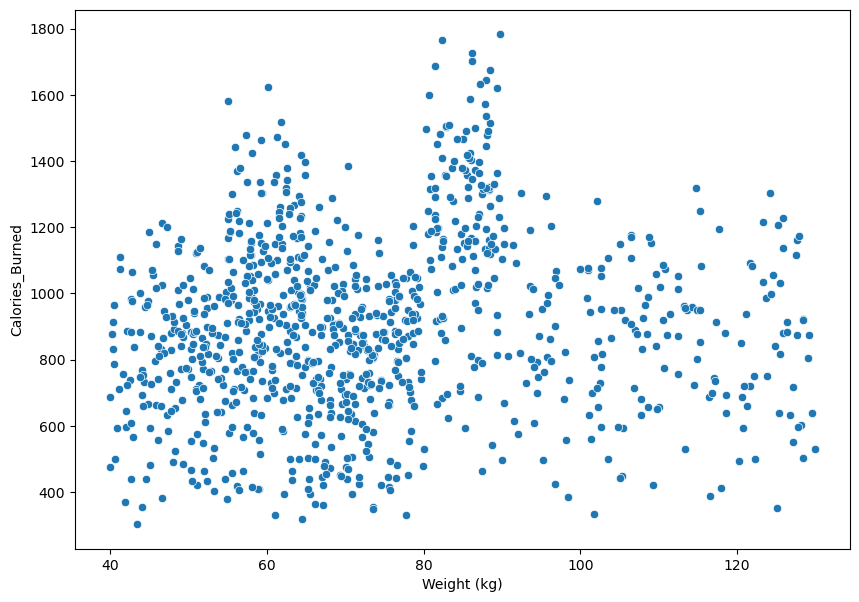

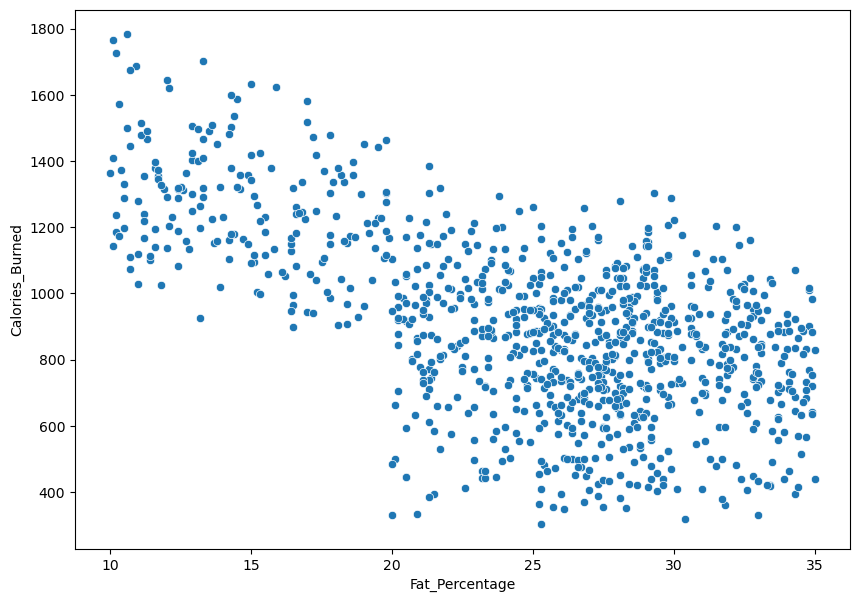

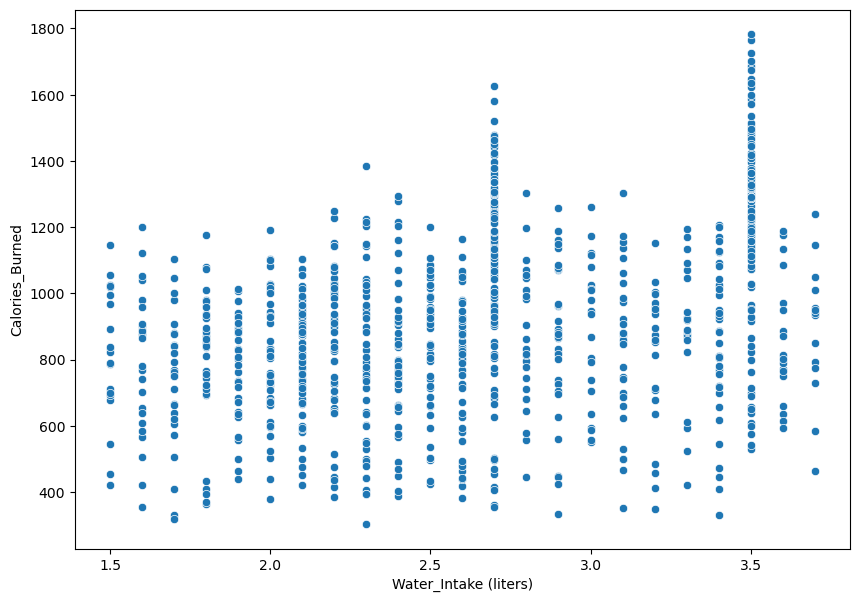

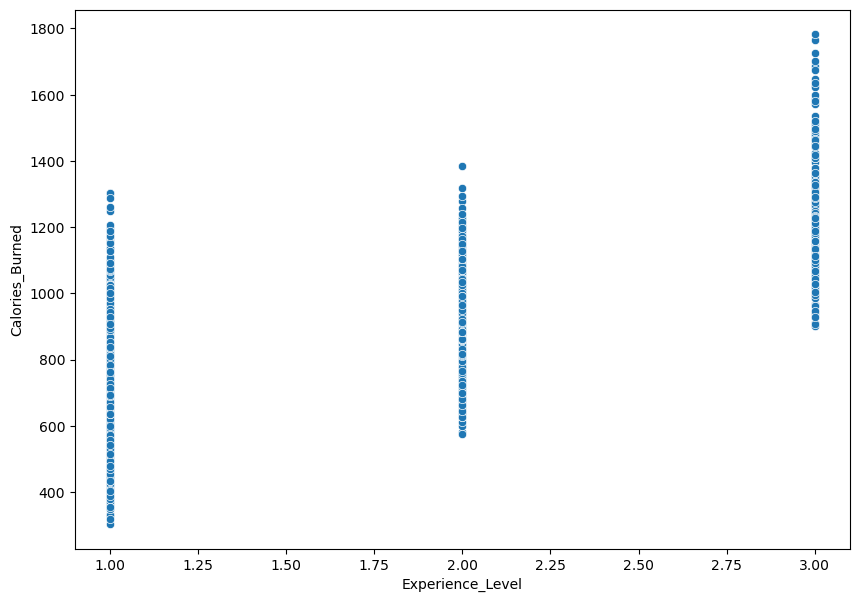

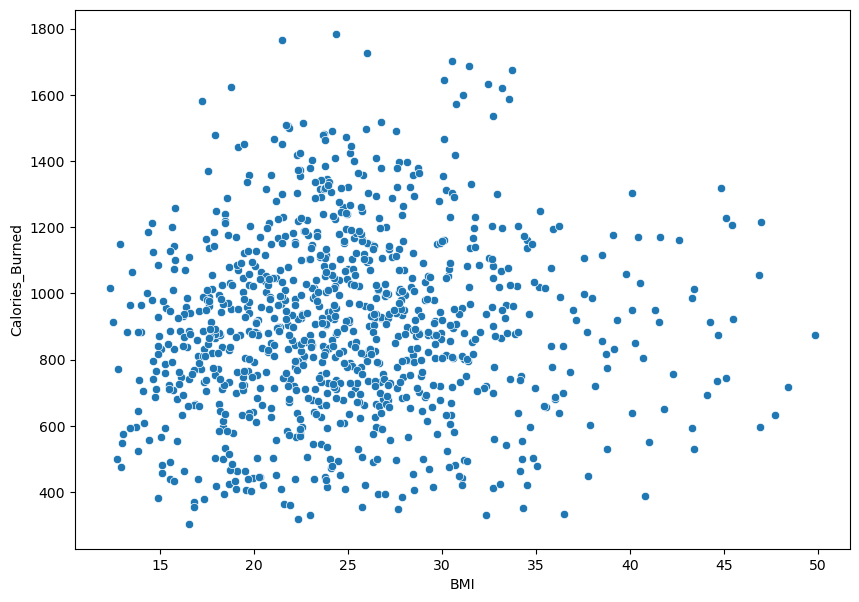

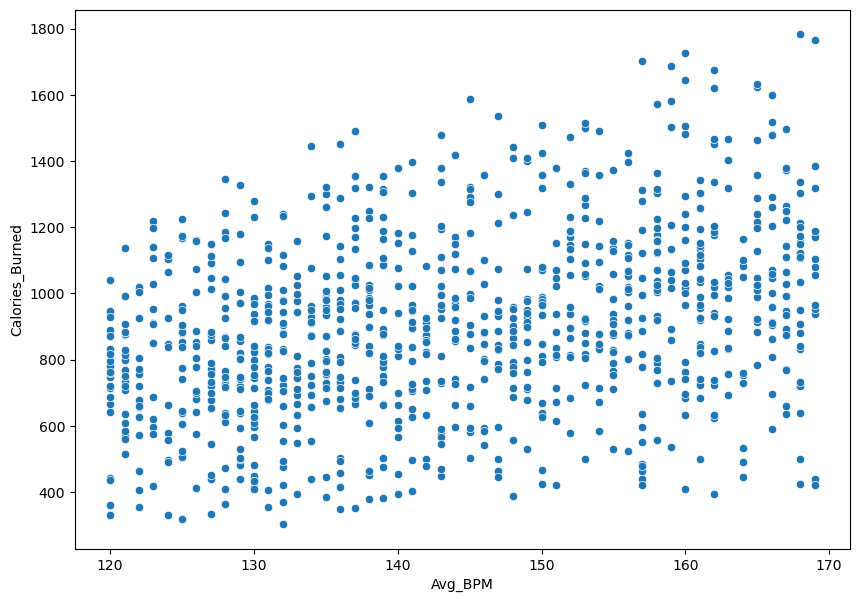

In [16]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x = "Workout_Type", y="Calories_Burned")

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x = "Session_Duration (hours)", y="Calories_Burned")

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x = "Workout_Frequency (days/week)", y="Calories_Burned")

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x = "Weight (kg)", y="Calories_Burned")

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x = "Fat_Percentage", y="Calories_Burned")

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x = "Water_Intake (liters)", y="Calories_Burned")

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x = "Experience_Level", y="Calories_Burned")

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x = "BMI", y="Calories_Burned")

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x = "Avg_BPM", y="Calories_Burned")

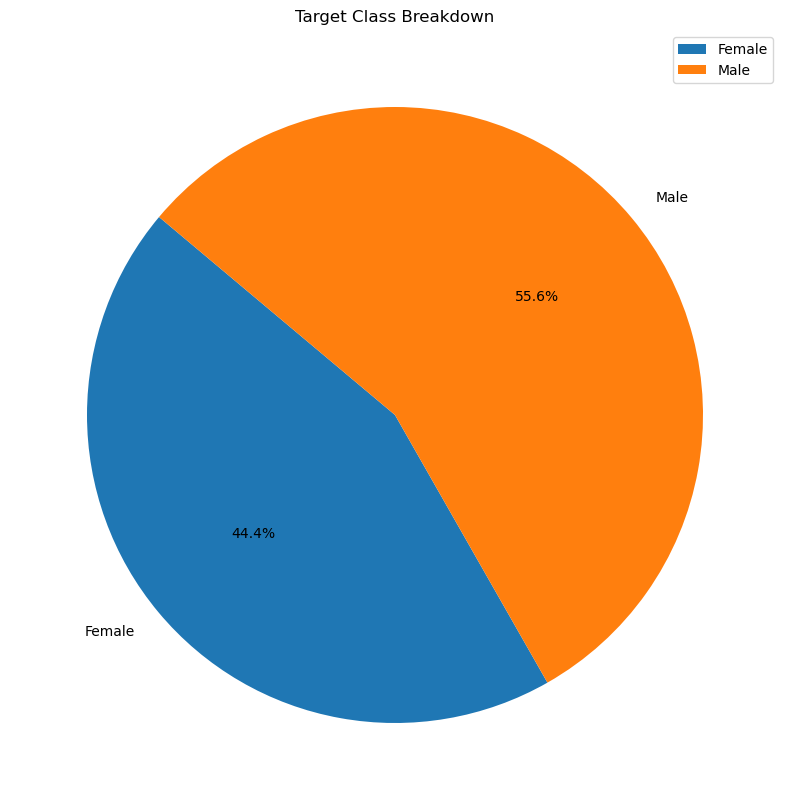

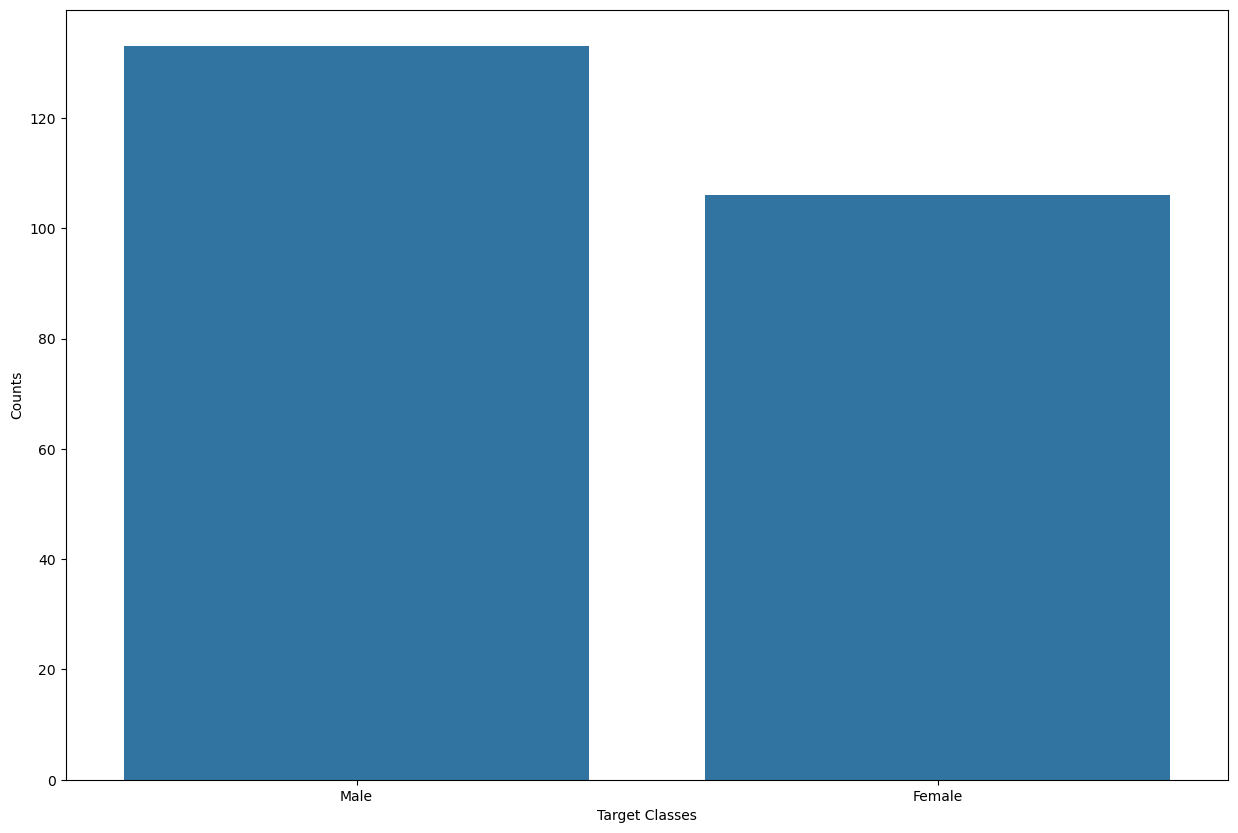

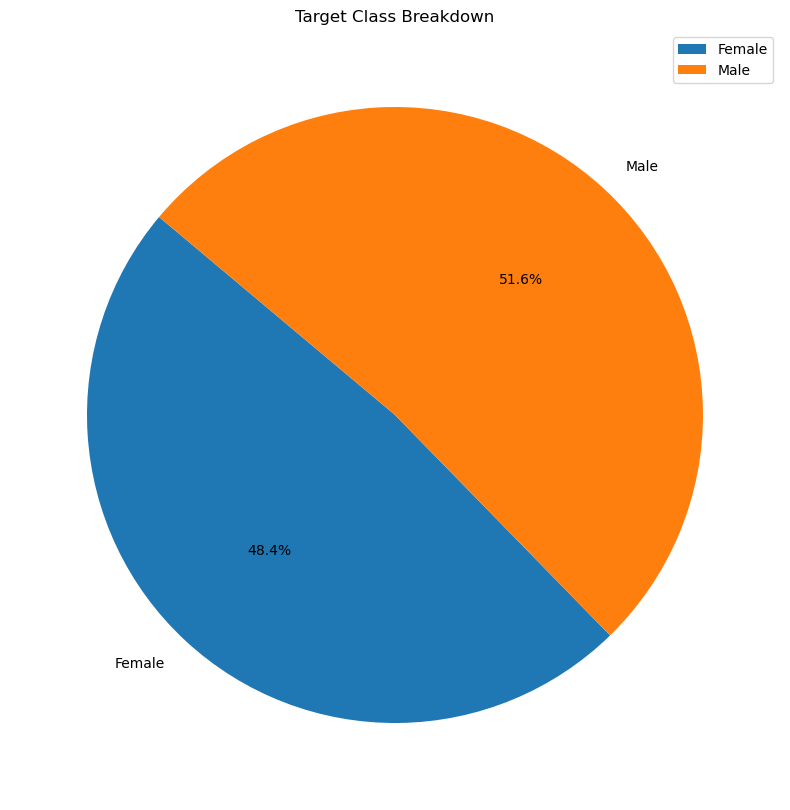

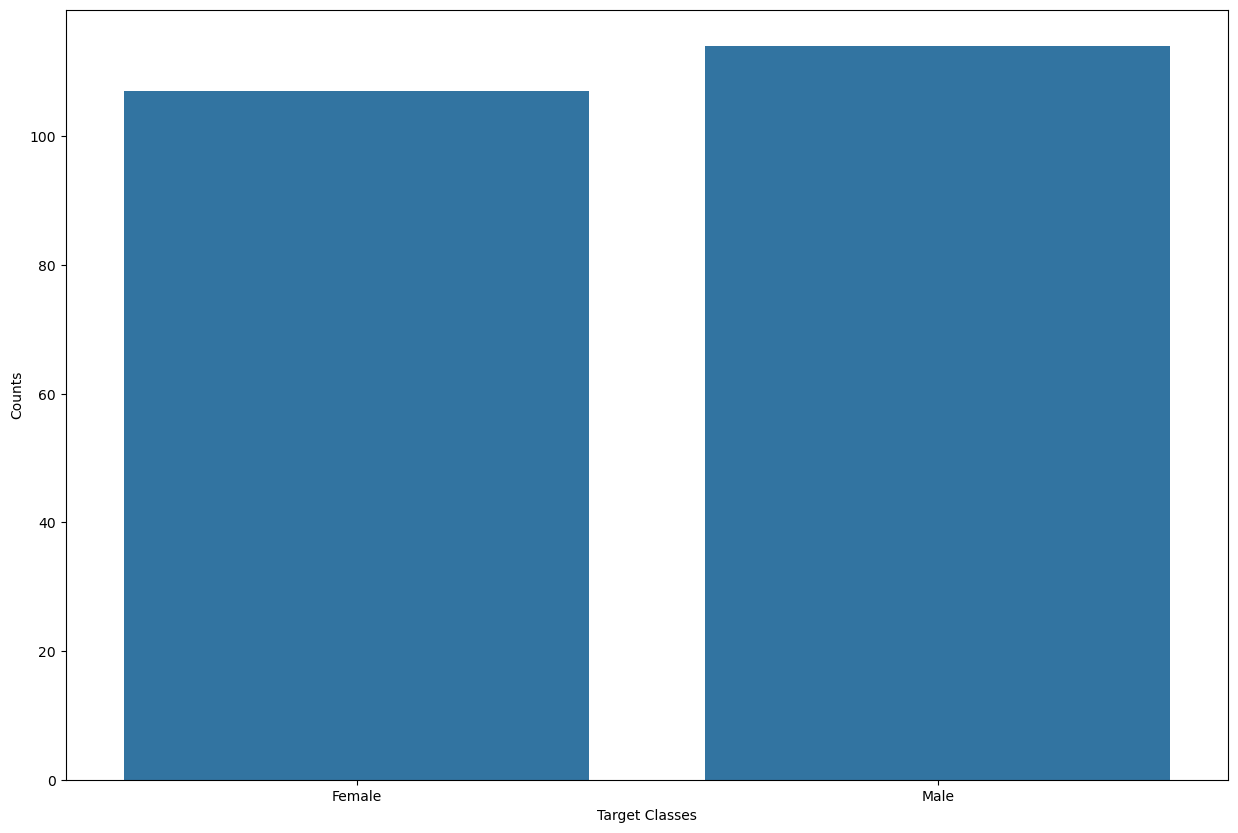

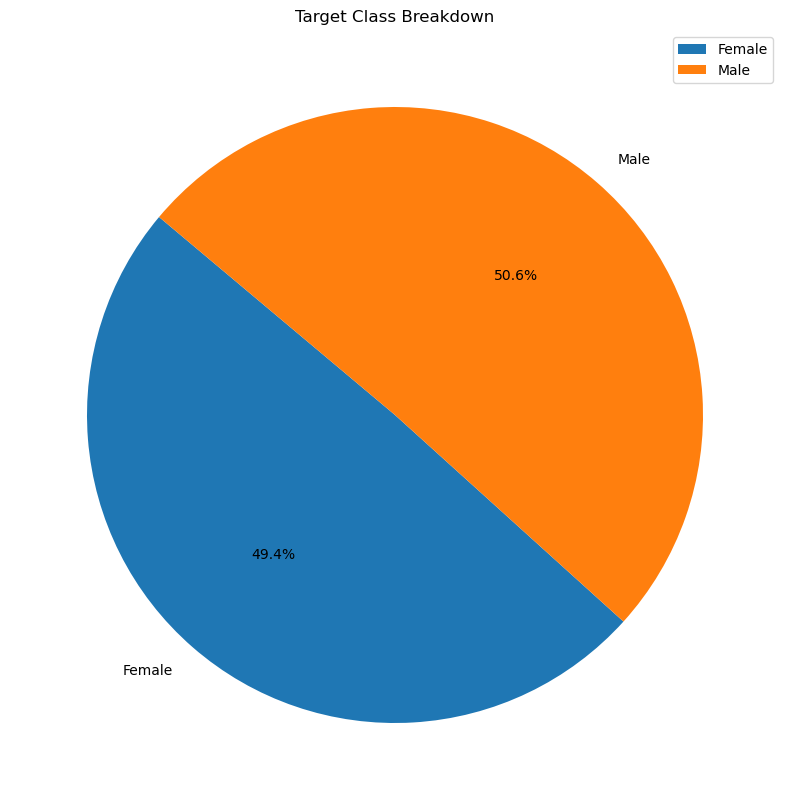

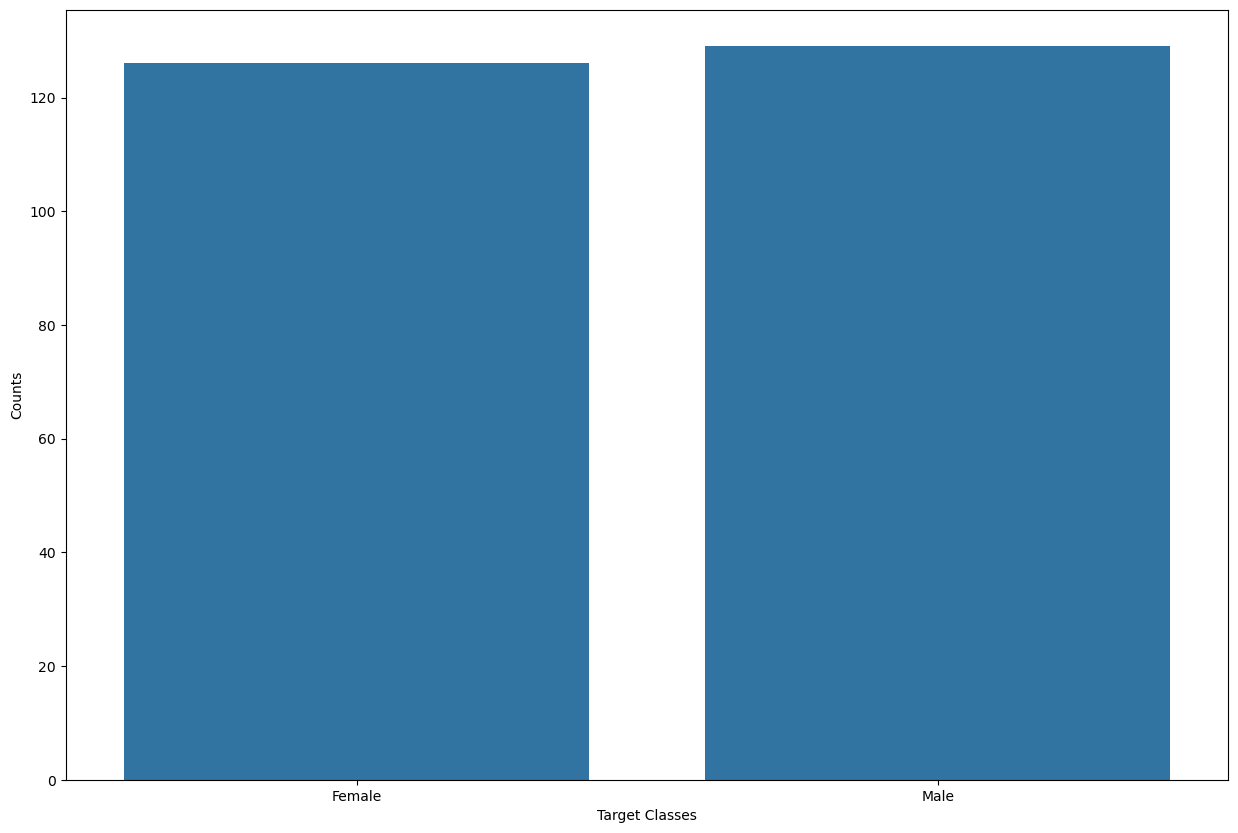

In [17]:
yoga = df[df["Workout_Type"] == "Yoga"]
hit = df[df["Workout_Type"] == "HIIT"]
cardio = df[df["Workout_Type"] == "Cardio"]
check_class_imbalance(yoga["Gender"])
check_class_imbalance(hit["Gender"])
check_class_imbalance(cardio["Gender"])

In [18]:
numerical_types.drop("Experience_Level", axis=1 , inplace=True)

In [28]:
df["Experience_Level"] = df["Experience_Level"].apply(lambda x: x-1)

# Separate X & Y variables

In [19]:
X = df.drop("Experience_Level", axis=1)
y = df["Experience_Level"]

# Create Preprocessor

In [20]:
preprocessor = create_column_transformer(categorical_types.columns, numerical_types.columns)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['Gender', 'Workout_Type'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
       'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage',
       'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'BMI'],
      dtype='object'))])

# PCA Analysis

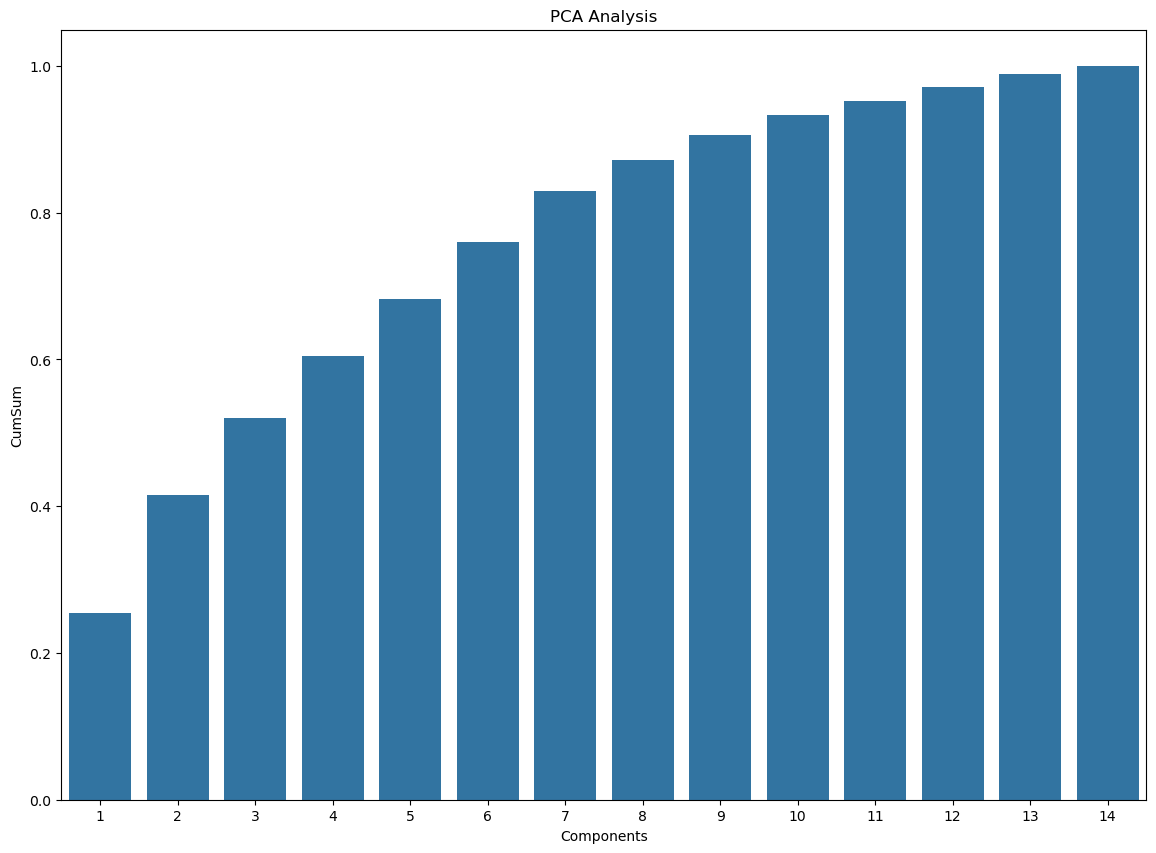

,Component,CumSum
0,1,0.254752
1,2,0.414986
2,3,0.520264
3,4,0.604323
4,5,0.682711
5,6,0.760245
6,7,0.829928
7,8,0.872417
8,9,0.906291
9,10,0.933022


In [21]:
pca_analysis(X, preprocessor)

# Create Metrics

In [22]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="macro")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='macro')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='macro')

# Test Dummy Models

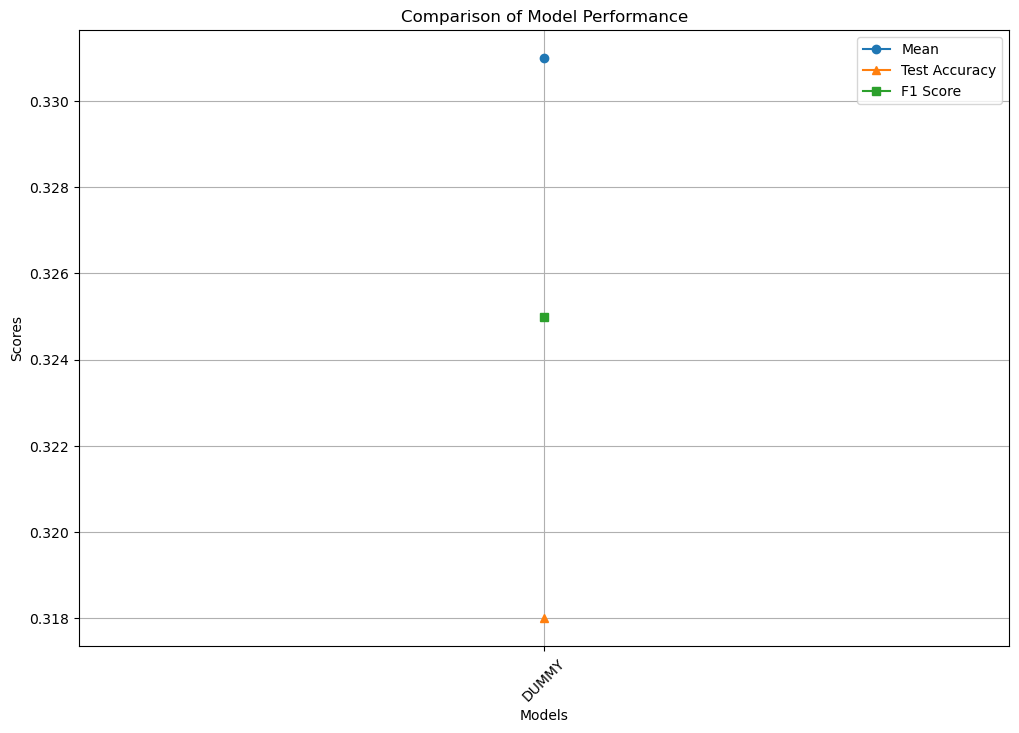

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
0,DUMMY,0.331,0.002,0.043,0.318,0.318,0.346,0.325


In [23]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
test_selected_models(preprocessor,model_name, models, X, y, acc_metric)

# Test K Best Columns

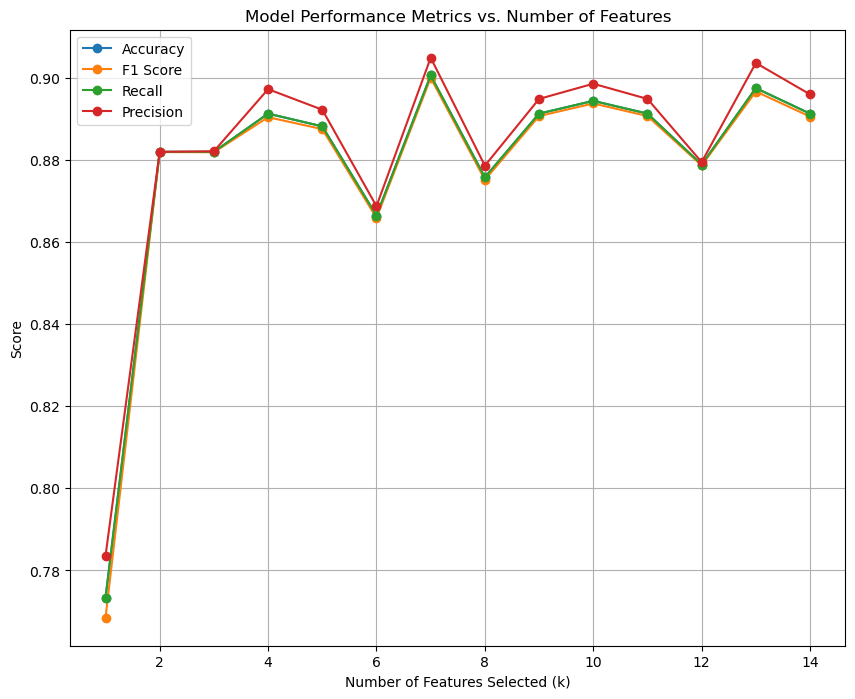

,Model,K,Selected Featured,acc_metric,f1_metric,recall,precision
0,RFC,1,Session_Duration (hours),0.773292,0.768481,0.773292,0.783538
1,RFC,2,"Session_Duration (hours), Workout_Frequency (d...",0.881988,0.881949,0.881988,0.881992
2,RFC,3,"Session_Duration (hours), Fat_Percentage, Work...",0.881988,0.881896,0.881988,0.882133
3,RFC,4,"Session_Duration (hours), Calories_Burned, Fat...",0.891304,0.890432,0.891304,0.897264
4,RFC,5,"Session_Duration (hours), Calories_Burned, Fat...",0.888199,0.887526,0.888199,0.892253
5,RFC,6,"Weight (kg), Session_Duration (hours), Calorie...",0.866460,0.865886,0.866460,0.868743
6,RFC,7,"Weight (kg), Session_Duration (hours), Calorie...",0.900621,0.900023,0.900621,0.904924
7,RFC,8,"Age, Weight (kg), Session_Duration (hours), Ca...",0.875776,0.875175,0.875776,0.878616
8,RFC,9,"Workout_Type_HIIT, Workout_Type_Yoga, Weight (...",0.891304,0.890716,0.891304,0.894886
9,RFC,10,"Gender_Female, Workout_Type_Yoga, Weight (kg),...",0.894410,0.893774,0.894410,0.898589


In [24]:
model_name = ["RFC"]
models = grab_selected_models(model_name)[0]
metric = mutual_info_classif
test_kbest_columns(preprocessor, X, y, models, model_name[0], metric)

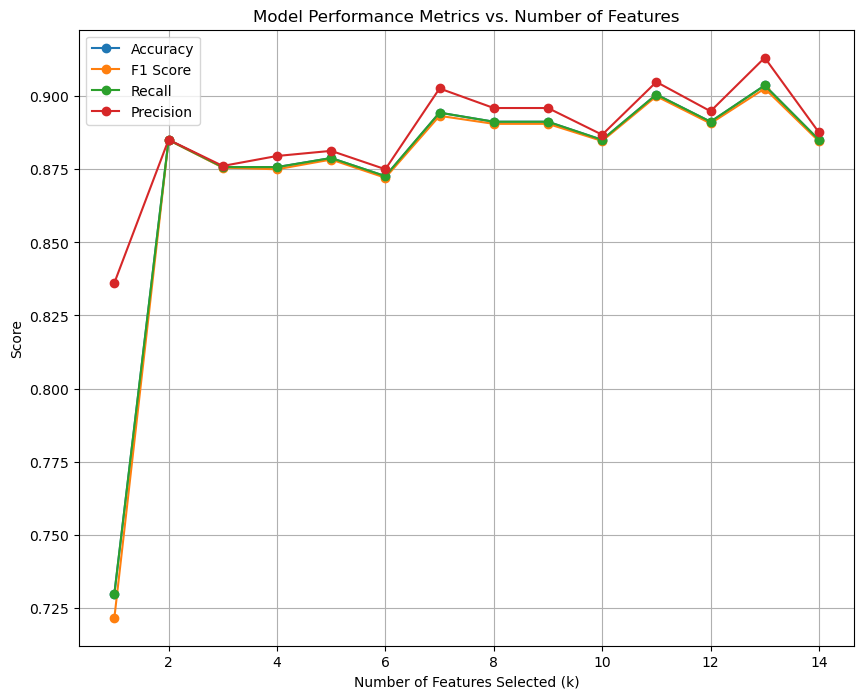

,Model,K,Selected Featured,acc_metric,f1_metric,recall,precision
0,RFC,1,Workout_Frequency (days/week),0.729814,0.721562,0.729814,0.836177
1,RFC,2,"Session_Duration (hours), Workout_Frequency (d...",0.885093,0.885031,0.885093,0.885155
2,RFC,3,"Session_Duration (hours), Fat_Percentage, Work...",0.875776,0.875609,0.875776,0.876176
3,RFC,4,"Session_Duration (hours), Calories_Burned, Fat...",0.875776,0.875029,0.875776,0.879581
4,RFC,5,"Session_Duration (hours), Calories_Burned, Fat...",0.878882,0.878362,0.878882,0.881337
5,RFC,6,"Workout_Type_Cardio, Session_Duration (hours),...",0.872671,0.872124,0.872671,0.875040
6,RFC,7,"Workout_Type_Cardio, Max_BPM, Session_Duration...",0.894410,0.893321,0.894410,0.902693
7,RFC,8,"Workout_Type_Cardio, Workout_Type_Yoga, Max_BP...",0.891304,0.890581,0.891304,0.895995
8,RFC,9,"Workout_Type_Cardio, Workout_Type_Yoga, Height...",0.891304,0.890581,0.891304,0.895995
9,RFC,10,"Workout_Type_Cardio, Workout_Type_Strength, Wo...",0.885093,0.884714,0.885093,0.886852


In [25]:
metric = f_classif
test_kbest_columns(preprocessor, X, y, models, model_name[0], metric)

# F-Stat Gives the best performance

In [27]:
metric = SelectKBest(score_func=f_classif, k=11)
model_names = ["LR", "SVC", "KNN", "CAT", "RFC", "GBC", "XGB"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor, model_names, models, X, y, acc_metric, metric)

ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [1 2 3]
